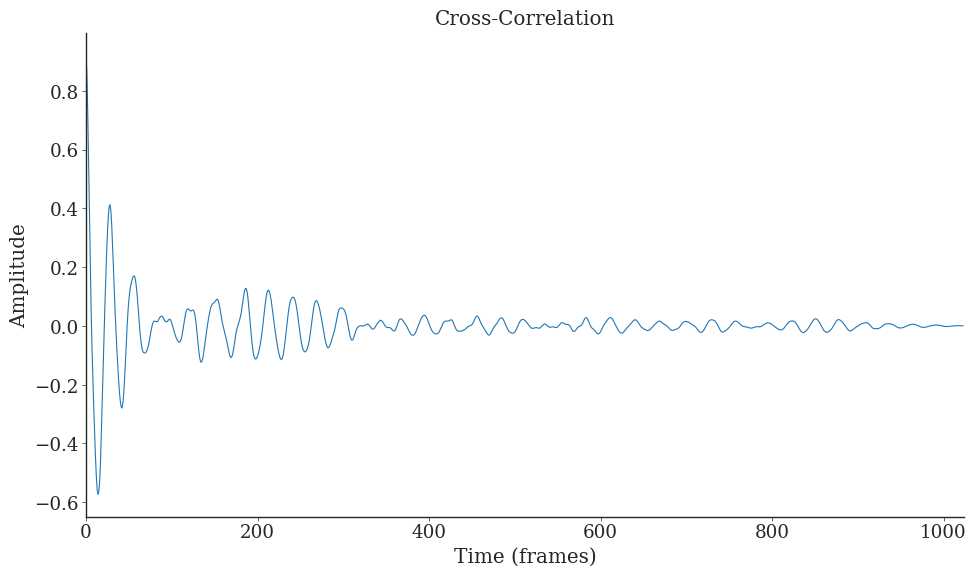

In [11]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import librosa
from egaznepy.visualize import apply_plot_style
from tqdm.notebook import tqdm
apply_plot_style(1.5)

# Load the audio sample

audio_path = '/dataHDD/chsaikeerthi/2024-chirumamilla/data/TIMIT/SA1ABC0/signal.wav'
y, sr = librosa.load(audio_path, sr=None)
# Parameters
frame_size = 1024
hop_size = 512

def plot_graph(x, y, title, filename=None):
    plt.rcParams['text.usetex'] = False
    plt.figure(figsize=(10, 6))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('Time (frames)')
    plt.ylabel('Amplitude')
    plt.xlim(0, len(y))
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='pdf')
    else:
        plt.show()

# Short-Term Cross-Correlation
def stcc(signal, frame_size, hop_size):
    frames = librosa.util.frame(signal, frame_length=frame_size, hop_length=hop_size)
    correlations = []
    for frame in frames.T:
        correlation = np.correlate(frame, frame, mode='full')
        correlations.append(correlation[len(correlation) // 2:])
    correlations = np.array(correlations)
    return correlations.mean(axis=0)

# Average Magnitude Difference Function
def amdf(signal, frame_size, hop_size):
    frames = librosa.util.frame(signal, frame_length=frame_size, hop_length=hop_size)
    amd = []
    for frame in frames.T:
        diff = np.array([np.mean(np.abs(frame - np.roll(frame, i))) for i in range(frame_size)])
        amd.append(diff)
    amd = np.array(amd)
    return amd.mean(axis=0)

# Compute and plot STCC
stcc_values = stcc(y, frame_size, hop_size)
plot_graph(np.arange(len(stcc_values)), stcc_values, 'Cross-Correlation', 'stcc_plot.pdf')


## Pitch labels range Gender wise


/dataHDD/chsaikeerthi/2024-chirumamilla
Data folder: data/TIMIT
Train set length: 630
Validation set length: 630
Test set length: 5038
Data set-up done successfully.
Train dataset: <torch.utils.data.dataset.Subset object at 0x7ff914afe200>
Validation dataset: <torch.utils.data.dataset.Subset object at 0x7ff914afd8d0>
Test dataset: <torch.utils.data.dataset.Subset object at 0x7ff914afda20>


/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


  0%|          | 0/5038 [00:00<?, ?it/s]

Data collected successfully


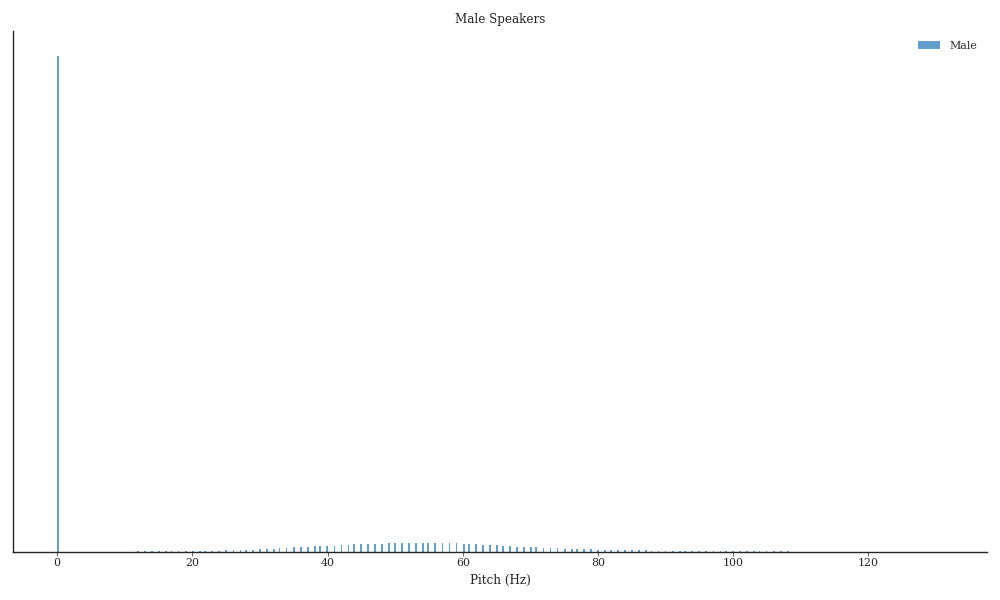

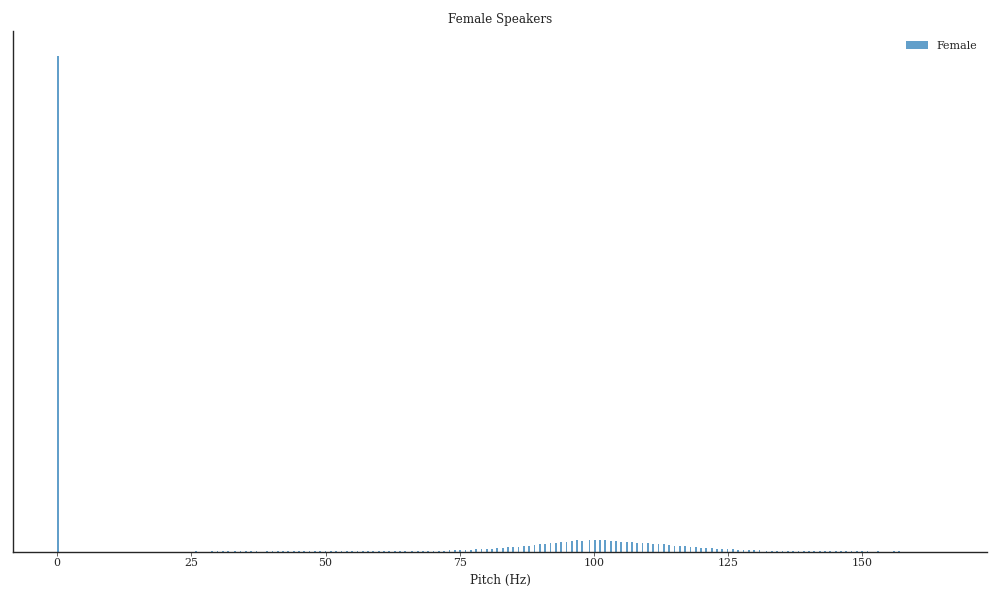

In [4]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import hydra

apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)

def collect_data(dataset):
    all_pitches_male = []
    all_probabilities_male = []
    all_pitches_female = []
    all_probabilities_female = []

    for data in tqdm(dataset):
        speech, pitch, probability, energy, gender = data  # Assuming gender information is available in the dataset
        if gender == "M":
            all_pitches_male.extend(pitch.numpy())
            all_probabilities_male.extend(probability.numpy())
        elif gender == "F":
            all_pitches_female.extend(pitch.numpy())
            all_probabilities_female.extend(probability.numpy())

    return (
        np.array(all_pitches_male), np.array(all_probabilities_male),
        np.array(all_pitches_female), np.array(all_probabilities_female)
    )

def plot_pitch_probability_histogram(pitches, probabilities, gender_label, color):
    plt.figure(figsize=(10, 6))
    
    # Histogram with the same range as the combined plot
    pitches = pitches.argmax(axis=1)
    plt.hist(pitches, bins=500, alpha=0.7, density=True)
    
    plt.xlabel('Pitch (Hz)')
    
    plt.title(f'{gender_label} Speakers')
    plt.yticks([])
    plt.legend([gender_label])
    plt.grid()
    plt.tight_layout()
    plt.show()

# Load configuration
config_path_predict = "weights/joint/2024-05-29_17-03-54/.hydra/config.yaml"  # Adjust this to your actual config path
config_predict = OmegaConf.load(config_path_predict)

# Instantiate the data module and model
datamodule_predict = hydra.utils.instantiate(config_predict.data, slice_length=4, train_val_test_split=[0.1, 0.1, 0.8], output_type= "class_label")
pitch_module = hydra.utils.instantiate(config_predict.model)

# Prepare the data
datamodule_predict.setup(stage="predict")

# Extract datasets
train_dataset = datamodule_predict.data_train
val_dataset = datamodule_predict.data_val
test_dataset = datamodule_predict.data_test

# Check that the dataset is loaded
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

# Collect data from the test dataset
pitches_male, probabilities_male, pitches_female, probabilities_female = collect_data(test_dataset)
print("Data collected successfully")

# Plot the collected data for males
plot_pitch_probability_histogram(pitches_male, probabilities_male, 'Male', 'blue')

# Plot the collected data for females
plot_pitch_probability_histogram(pitches_female, probabilities_female, 'Female', 'red')


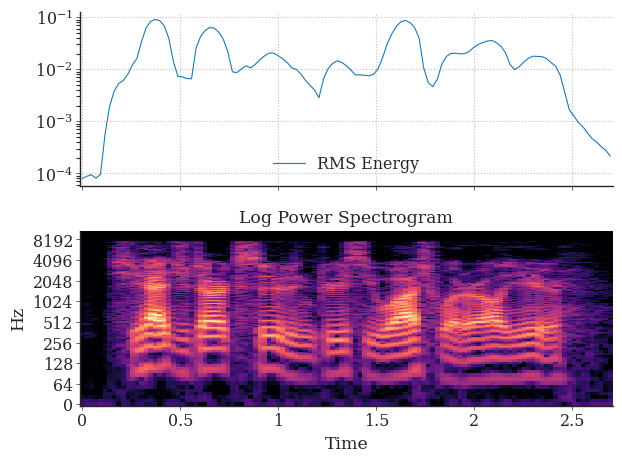

In [9]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from egaznepy.visualize import apply_plot_style
plt.rcParams['text.usetex'] = False
#apply_plot_style(1.3)

# Load audio file
y, sr = librosa.load("/dataHDD/chsaikeerthi/2024-chirumamilla/data/TIMIT/SA1ABC0/signal.wav")

# Compute short-time Fourier transform and RMS energy
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(y=y)

# Create subplots
fig, ax = plt.subplots(nrows=2, sharex=True)

# Plot RMS energy
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()

# Plot log power spectrogram
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Log Power Spectrogram')

# Save the figure as a PDF
plt.savefig("results/rms.pdf", format='pdf', dpi=800)

# Show the plot (optional, you can remove this line if you don't need to display the plot)
plt.show()


To visualize the pitches from the ground truth

/dataHDD/chsaikeerthi/2024-chirumamilla
Data folder: data/TIMIT
batch_size 64
Train set length: 630
Validation set length: 630
Test set length: 5038
Data set-up done successfully.
Train dataset: <torch.utils.data.dataset.Subset object at 0x7f244c1110f0>
Validation dataset: <torch.utils.data.dataset.Subset object at 0x7f244c111360>
Test dataset: <torch.utils.data.dataset.Subset object at 0x7f244c110ac0>


/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


  0%|          | 0/5038 [00:00<?, ?it/s]

Data collected successfully


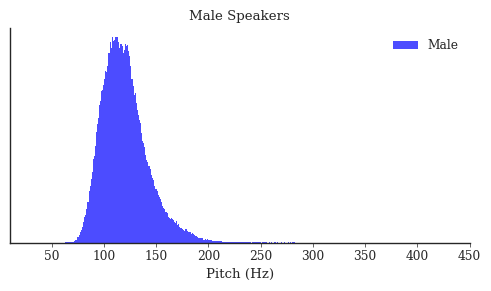

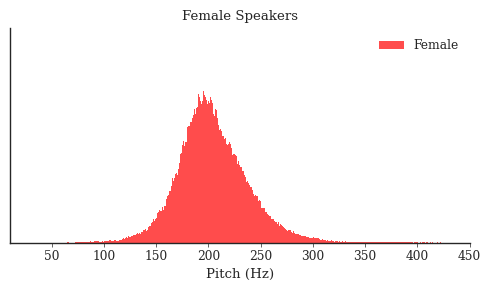

In [5]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import hydra
from egaznepy.visualize import apply_plot_style
from tqdm.notebook import tqdm
apply_plot_style(1.0)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)

def collect_data(dataset):
    all_pitches_male = []
    all_probabilities_male = []
    all_pitches_female = []
    all_probabilities_female = []

    for data in tqdm(dataset):
        speech, pitch, probability, energy, gender = data  # Assuming gender information is available in the dataset
        if gender == "M":
            all_pitches_male.extend(pitch.numpy())
            all_probabilities_male.extend(probability.numpy())
        elif gender == "F":
            all_pitches_female.extend(pitch.numpy())
            all_probabilities_female.extend(probability.numpy())

    return (
        np.array(all_pitches_male), np.array(all_probabilities_male),
        np.array(all_pitches_female), np.array(all_probabilities_female)
    )



# Load configuration
config_path_predict = "weights/joint/2024-05-29_17-03-54/.hydra/config.yaml"  # Adjust this to your actual config path

config_predict = OmegaConf.load(config_path_predict)

# Instantiate the data module and model
datamodule_predict = hydra.utils.instantiate(config_predict.data, slice_length=4, train_val_test_split=[0.1, 0.1, 0.8], output_type= "hz")
pitch_module = hydra.utils.instantiate(config_predict.model)

# Prepare the data
datamodule_predict.setup(stage="predict")

# Extract datasets
train_dataset = datamodule_predict.data_train
val_dataset = datamodule_predict.data_val
test_dataset = datamodule_predict.data_test

# Check that the dataset is loaded
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

# Collect data from the test dataset
pitches_male, probabilities_male, pitches_female, probabilities_female = collect_data(test_dataset)
print("Data collected successfully")

# Plot the collected data for males
plot_pitch_probability_histogram(pitches_male, probabilities_male, 'Male', 'blue')

# Plot the collected data for females
plot_pitch_probability_histogram(pitches_female, probabilities_female, 'Female', 'red')


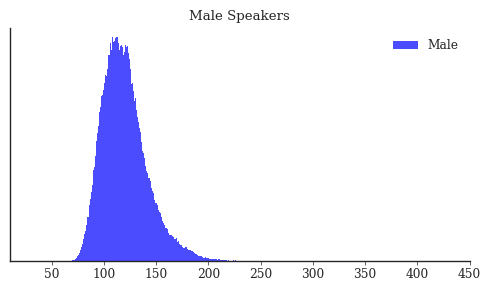

In [9]:
def plot_pitch_probability_histogram(pitches, probabilities, gender_label, color):
    plt.figure(figsize=(5, 3))
    
    # Histogram with the same range as the combined plot
    #pitches = pitches.argmax(axis=1)
    plt.hist(pitches, bins=500, alpha=0.7, density=True, color=color, weights=probabilities)
    
    #plt.xlabel('Pitch (Hz)')
    
    plt.title(f'{gender_label} Speakers')
    plt.yticks([])
    
    plt.legend([gender_label])
    plt.grid()
    plt.xlim(10,450)
    plt.ylim(0,0.021)
    #plt.tight_layout()
    plt.savefig("results/pitch_histogram_male.pdf", format='pdf', dpi=800)
    plt.show()


plot_pitch_probability_histogram(pitches_male, probabilities_male, 'Male', 'blue')

# Plot the collected data for females
#plot_pitch_probability_histogram(pitches_female, probabilities_female, 'Female', 'red')

In [39]:
import torchcrepe


# Load audio
audio, sr = torchcrepe.load.audio("/dataHDD/chsaikeerthi/2024-chirumamilla/data/TIMIT/SA1ABC0/signal.wav")
print(audio.shape, sr)
# Here we'll use a 5 millisecond hop length
hop_length = int(sr / 200.)

# Provide a sensible frequency range for your domain (upper limit is 2006 Hz)
# This would be a reasonable range for speech
fmin = 50
fmax = 550

# Select a model capacity--one of "tiny" or "full"
model = 'tiny'

# Choose a device to use for inference
device = 'cuda:0'

# Pick a batch size that doesn't cause memory errors on your gpu
batch_size = 1

# Compute pitch using first gpu
pitch = torchcrepe.predict(audio,
                           sr,
                           hop_length,
                           fmin,
                           fmax,
                           model,
                           batch_size=batch_size,
                           device=device)

torch.Size([1, 43418]) 16000


In [4]:
print(pitch)

tensor([[165.0255, 163.2656, 164.2807, 349.8735, 349.7222, 344.5868, 341.7639,
         339.7491, 336.5948, 324.1257, 323.3876, 355.1761, 328.8171, 330.0146,
         163.4695, 163.1626, 165.2942, 169.2259, 145.4013, 170.4744, 179.3888,
          77.2158,  59.6749,  80.2553,  58.4669, 477.7886, 116.6157, 351.0836,
         350.1521, 208.5828, 213.6637, 211.5426, 213.7926, 213.3180, 212.0708,
         432.3564, 438.3422, 434.0206, 441.6409, 445.9467, 440.1152, 439.2293,
         435.0352, 438.1193, 435.7968, 437.1608, 432.9585, 295.6888, 351.3550,
         356.4244, 356.0633, 365.5229, 370.2336,  95.6461,  97.7987,  98.7605,
         100.0217,  99.0862, 102.0731, 102.9980, 104.6074, 105.5888, 106.5001,
         107.1762, 111.0750, 112.9734, 114.2528, 113.9615, 113.9262, 113.7856,
         113.7852, 113.7197, 110.9837, 110.3073, 110.2646, 108.4851, 109.1698,
         109.5427, 109.7324, 108.8859, 108.0846, 110.4048, 112.0374, 111.9565,
         112.8874, 113.7672, 114.2420, 113.8605, 113

In [38]:
import numpy as np

# Load RCA values from CSV file
rca_values = np.loadtxt('/dataHDD/chsaikeerthi/2024-chirumamilla/logs/eval/runs/2024-08-08_15-35-31_FINAL_test_yaapt_model_timit/tensorboard/version_0/rca_per_utt.csv', delimiter=',')

# Calculate average RCA
average_rca = np.mean(rca_values)
print("Average RCA from CSV:", average_rca)


Average RCA from CSV: 0.2649047653076752


/tmp/ipykernel_1398359/4259575031.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=snr_levels, y=eval(f'rca_{model.lower()}'), color=color, linestyle=linestyle, ci=None)
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_1398359/4259575031.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=snr_levels, y=e

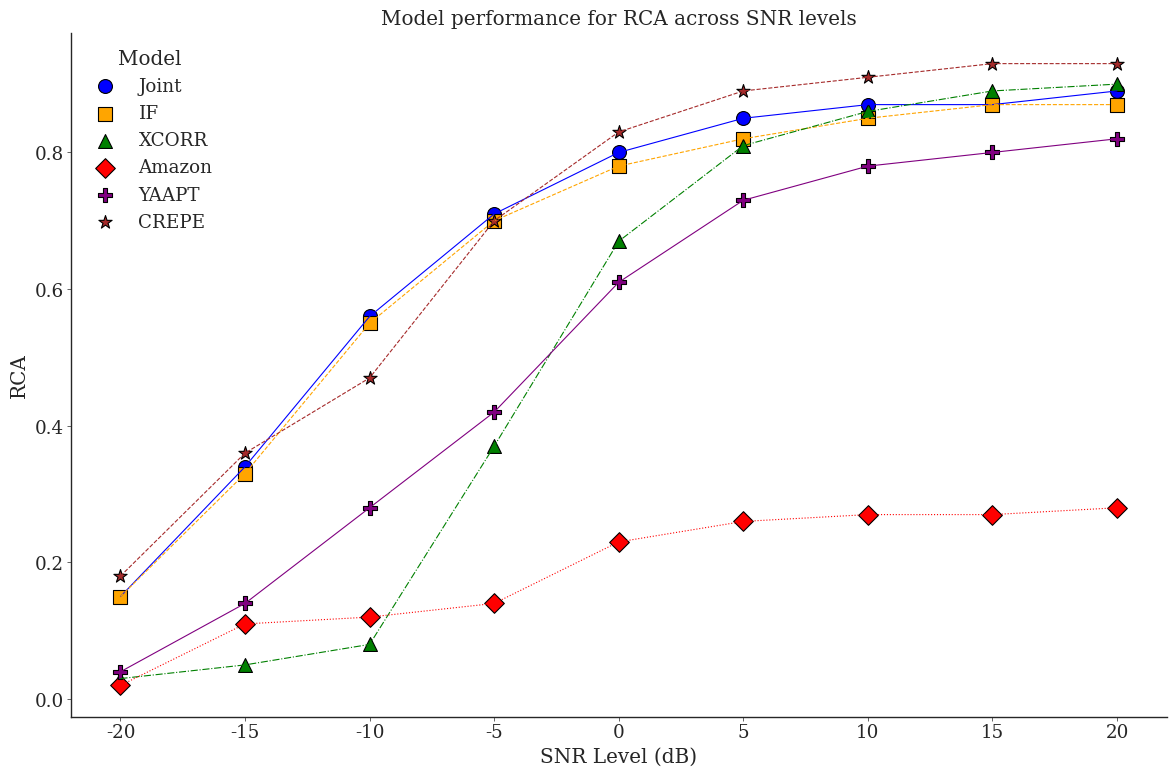

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from egaznepy.visualize import apply_plot_style
from matplotlib.ticker import FixedLocator, FixedFormatter

# Apply custom plot style
apply_plot_style(1.5)
plt.rcParams['text.usetex'] = False

# Define specific SNR levels
snr_levels = np.array([-20,-15, -10, -5, 0, 5, 10,15, 20])

# rca_joint = [0.06,0.33, 0.66, 0.79, 0.83, 0.89, 0.89,0.90, 0.92]
# rca_if = [0.07, 0.22, 0.58, 0.78, 0.83, 0.87,0.89,0.90,0.91]
# rca_xcorr = [0.04, 0.06,0.15, 0.40, 0.79, 0.93, 0.95,0.95, 0.97]
# rca_amazon = [0.15,0.26, 0.41, 0.55, 0.60, 0.63, 0.63,0.63, 0.64]
# rca_yaapt = [0.05,0.12, 0.27, 0.55, 0.72, 0.81, 0.84,0.83, 0.87]
# rca_crepe = [0.22,0.48, 0.57, 0.79, 0.80, 0.83, 0.92,0.92, 0.92] # KEELE

# rca_joint = [0.18,0.33,0.54, 0.66,0.73,0.82,0.82,0.84,0.85]
# rca_if = [0.18, 0.26,0.48,0.60,0.68,0.76,0.79,0.80,0.82]
# rca_xcorr = [0.04,0.05, 0.21, 0.61,0.76,0.83,0.87,0.88,0.88]
# rca_amazon = [0.14,0.18, 0.19,0.26,0.34,0.38,0.39,0.39,0.39]
# rca_yaapt = [0.05,0.28, 0.33,0.62, 0.76, 0.82,0.85,0.86, 0.87]
# rca_crepe = [0.24,0.36, 0.77, 0.86, 0.91, 0.92,0.92, 0.93, 0.93 ] # FDA

# rca_joint = [0.10,0.26,0.32,0.55,0.62,0.67,0.70,0.72,0.73]
# rca_if =    [0.10,0.21,0.41,0.53,0.60,0.65,0.68,0.70,0.72]
# rca_xcorr = [0.04, 0.08,0.12,0.32, 0.48,0.70,0.75,0.75,0.75]
# rca_amazon = [0.20,0.32,0.45,0.55,0.59,0.60,0.61,0.61,0.61]
# rca_yaapt = [0.05,0.11,0.21,0.53,0.76,0.80,0.82,0.83,0.85]
# rca_crepe = [0.39,0.42,0.76,0.83,0.86,0.88,0.88,0.89,0.89 ] # MOCHA_TIMIT

rca_joint = [0.15,0.34,0.56,0.71,0.80,0.85,0.87,0.87,0.89]
rca_if = [0.15, 0.33,0.55,0.70,0.78,0.82,0.85,0.87,0.87]
rca_xcorr = [0.03,0.05, 0.08,0.37, 0.67, 0.81, 0.86,0.89,0.90]
rca_amazon = [0.02,0.11,0.12,0.14,0.23,0.26,0.27,0.27,0.28]
rca_yaapt = [0.04,0.14, 0.28,0.42,0.61,0.73,0.78,0.80,0.82]
rca_crepe = [0.18,0.36, 0.47,0.70,0.83,0.89,0.91,0.93,0.93 ] # TIMIT







# Create a DataFrame for Seaborn
models = ['Joint', 'IF', 'XCORR', 'Amazon', 'YAAPT', 'CREPE']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
markers = ['o', 's', '^', 'D', 'P', '*']
linestyles = ['-', '--', '-.', ':', '-', '--']

# Plotting the curves and scatter points
plt.figure(figsize=(12, 8))

# Plot smooth curves using Seaborn lineplot
for model, color, linestyle in zip(models, colors, linestyles):
    sns.lineplot(x=snr_levels, y=eval(f'rca_{model.lower()}'), color=color, linestyle=linestyle, ci=None)

# Plot data points for each model
for model, color, marker in zip(models, colors, markers):
    sns.scatterplot(x=snr_levels, y=eval(f'rca_{model.lower()}'), color=color, marker=marker, s=100, edgecolor='black', label=model)

# Set custom ticks and labels for the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(FixedLocator(snr_levels))  # Set the position of the ticks
ax.xaxis.set_major_formatter(FixedFormatter([f'{i}' for i in snr_levels]))  # Format the tick labels

plt.xlabel('SNR Level (dB)')
plt.ylabel('RCA')
plt.title('Model performance for RCA across SNR levels')

# Customize legend to include both lines and points
plt.legend(title='Model')

plt.grid(False)
plt.savefig('results/rca_metric_plot_timit.pdf', format='pdf', dpi=600)
plt.show()


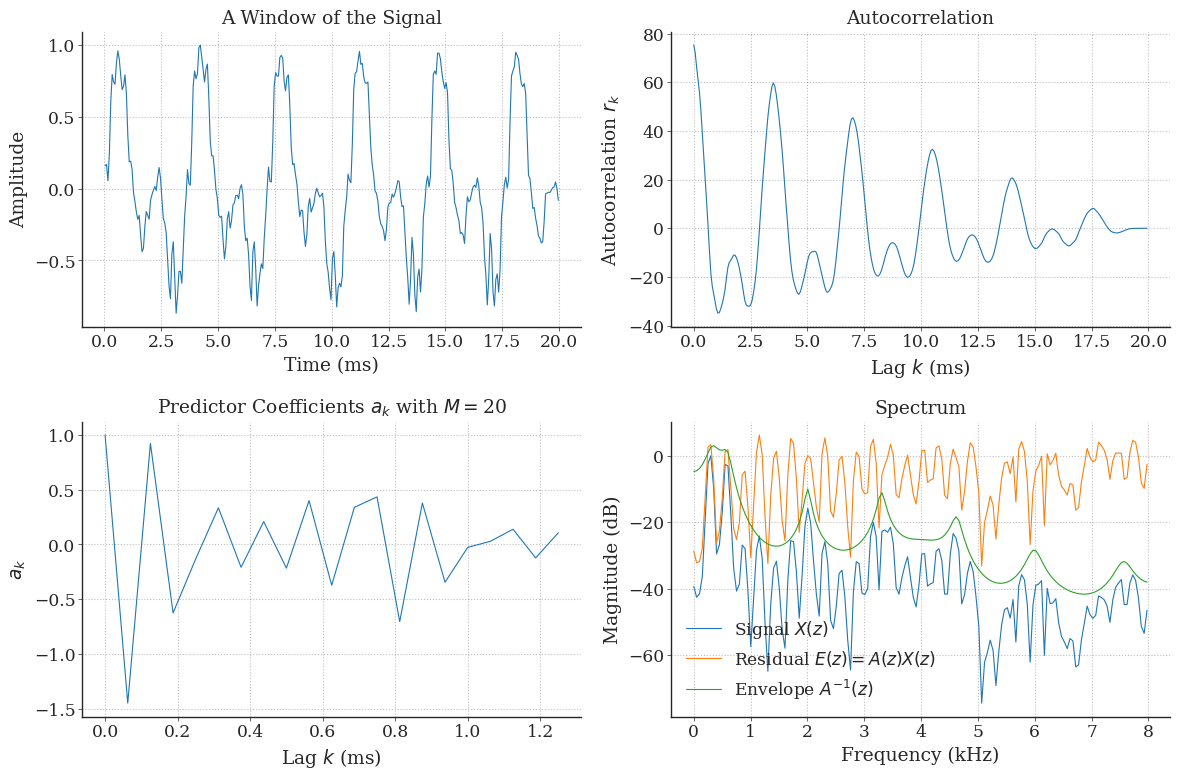

Plot saved to: results/lpc_plot.pdf


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz
from scipy.signal import resample
from egaznepy.visualize import apply_plot_style
apply_plot_style(1.4)
plt.rcParams['text.usetex'] = False

import os

target_fs = 16000

# Read from storage
filename = '/dataHDD/chsaikeerthi/2024-chirumamilla/data/MOCHA_TIMIT/faet0_001/signal.wav'
fs, data = wavfile.read(filename)
data = resample(data, int(len(data) * target_fs / fs))
fs = target_fs

lpc_length = int(1.25 * fs / 1000)
window_length_ms = 20
window_length = int(np.round(fs * window_length_ms / 1000))

n = np.linspace(0.5, window_length - 0.5, num=window_length)

windowpos = np.random.randint(int(len(data) - window_length))
window_function = np.sin(np.pi * n / window_length) ** 2

datawin = data[windowpos:(windowpos + window_length)]
datawin = datawin / np.max(np.abs(datawin))  # Normalize

# Calculate autocorrelation directly
autocorrelation = np.correlate(datawin, datawin, mode='full')
autocorrelation = autocorrelation[autocorrelation.size // 2:]  # Keep only the positive lags

# Prepare for LPC
b = np.zeros([lpc_length + 1, 1])
b[0] = 1.
a = solve_toeplitz(autocorrelation[0:lpc_length + 1], b)
a = a / a[0]
A = np.fft.fft(a[:, 0], n=window_length)
X = np.fft.fft(datawin * window_function)
f = np.linspace(0, fs / 1000, num=window_length)
fftlength = window_length // 2

# Ensure results directory exists
if not os.path.exists('results'):
    os.makedirs('results')

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(n * 1000 / fs, datawin)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('A Window of the Signal')

plt.subplot(222)
plt.plot(np.arange(len(autocorrelation)) * 1000 / fs, autocorrelation)
plt.xlabel('Lag $k$ (ms)')
plt.ylabel('Autocorrelation $r_k$')
plt.title('Autocorrelation')

plt.subplot(223)
plt.plot(np.arange(len(a)) * 1000 / fs, a)
plt.xlabel('Lag $k$ (ms)')
plt.ylabel('$a_k$')
plt.title(r'Predictor Coefficients $a_k$ with $M=$' + str(lpc_length))

plt.subplot(224)
plt.plot(f[0:fftlength], 20. * np.log10(np.abs(X[0:fftlength] / np.max(np.abs(X)))), label='Signal $X(z)$')
plt.plot(f[0:fftlength], 20. * np.log10(np.abs(X[0:fftlength] * A[0:fftlength])), label='Residual $E(z)= A(z)X(z)$')
plt.plot(f[0:fftlength], 3 - 20. * np.log10(np.abs(A[0:fftlength] / np.min(np.abs(A)))), label='Envelope $A^{-1}(z)$')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('Spectrum')
plt.legend()

plt.tight_layout()

# Save the plot
plot_path = 'results/lpc_plot.pdf'
plt.savefig(plot_path, format='pdf')

# Show the plot
plt.show()

# Confirm the file has been created
print(f"Plot saved to: {plot_path}")


residual [0.5844619  0.6624214  0.58499897 0.62051725 0.5995049  0.6215016
 0.61713487 0.61657846 0.6054593  0.62856    0.60451657 0.5992993
 0.61025935 0.60426366 0.6517442  0.5916313  0.62384206 0.59724724
 0.6316116  0.57009274 0.664921   0.55347395 0.6828737  0.491395
 1.         0.7266047  0.         0.7730719  0.7565435  0.6568742
 0.27772695 0.49701554 0.7238919  0.6700264  0.70080256 0.6326829
 0.5700309  0.58025485 0.657927   0.6212852  0.63860005 0.66764355
 0.6505597  0.6167001  0.80202585 0.77137154 0.60361594 0.4284228
 0.48151302 0.49965328 0.5367345  0.5906689  0.65932757 0.7024558
 0.7382958  0.71151483 0.62557983 0.5702869  0.5582858  0.5692525
 0.5351104  0.61864626 0.63247347 0.5704196  0.52526313 0.576729
 0.63680744 0.6488382  0.59995115 0.56729925 0.5748347  0.5964299
 0.64402854 0.66816604 0.6547797  0.6188611  0.63114065 0.66882133
 0.6918664  0.6506081  0.5905975  0.5810821  0.5530095  0.5273597
 0.57723165 0.65283513 0.66073203 0.6818796  0.6959986  0.6359337


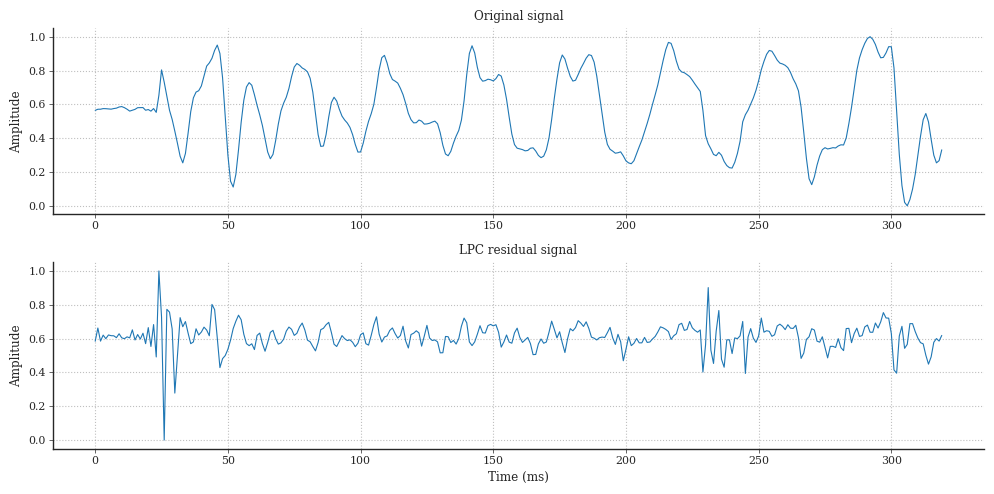

In [22]:
from LPCTorch.lpctorch.lpc import LPCCoefficients
import torch
import torchaudio
import numpy as np
import librosa
import matplotlib.pyplot as plt
import scipy
from torch.nn import functional as F
from egaznepy.visualize import apply_plot_style
plt.rcParams['text.usetex'] = False

apply_plot_style(1.7)

x, sr = torchaudio.load(librosa.ex('trumpet'))
x_pad = F.pad(x,(0,160))
samples = x[-1]
win_len = 320
frames = x_pad.unfold(-1,320,160)
lpc = LPCCoefficients(order=16)
lpcc = lpc(x)
coef= lpcc[-1,:,:]
residual = torch.empty_like(frames)
for frame in range(frames.size(1)):
    res = scipy.signal.lfilter(np.array(coef[frame,:]), np.array([1]), frames[:, frame])
    residual[:, frame,:] = torch.Tensor(res)

frame_index = 0  # change this to select a different frame
frames_np = frames[0, frame_index].numpy()
residual_np = residual[0, frame_index].numpy()

# Normalize the data
frames_np_norm = (frames_np - frames_np.min()) / (frames_np.max() - frames_np.min())
residual_np_norm = (residual_np - residual_np.min()) / (residual_np.max() - residual_np.min())
print("residual",residual_np_norm)
print('frames_np_norm:', frames_np_norm.min(), frames_np_norm.max(), frames_np_norm.mean())
print('residual_np_norm:', residual_np_norm.min(), residual_np_norm.max(), residual_np_norm.mean())
print('Shape of residual:', residual.shape)
apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(frames_np_norm)  
plt.title('Original signal')

plt.ylabel('Amplitude')


# Plot the residual
plt.subplot(2, 1, 2)
plt.plot(residual_np_norm)  # plot only every 10th sample
plt.title('LPC residual signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig('results/lpc_residual.pdf', format='pdf', dpi=1200)
plt.show()

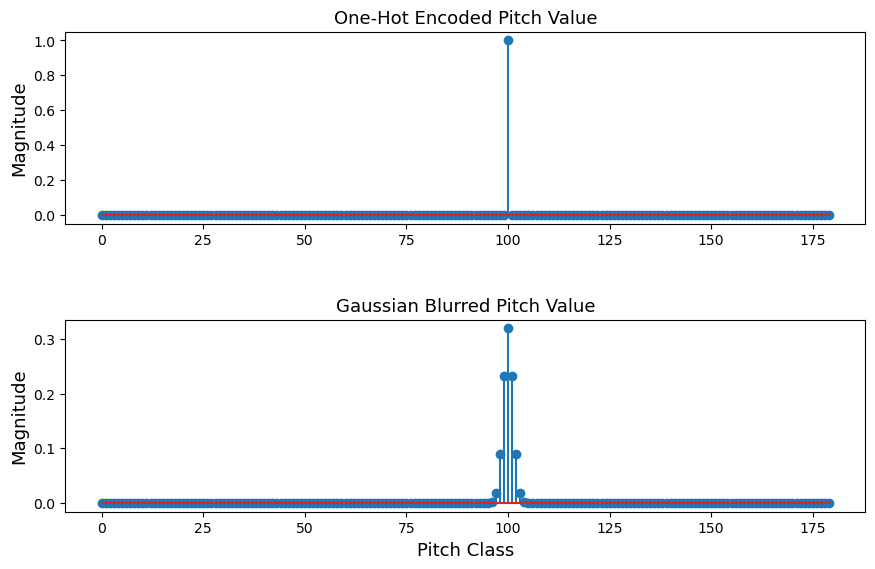

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from egaznepy.visualize import apply_plot_style
import matplotlib as mpl

# Reset to default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['text.usetex'] = False

# Apply plot style
#apply_plot_style(1.0)

# Generate a one-hot encoded pitch value (example)
pitch_value = np.zeros(180)
pitch_value[100] = 1  # Assuming pitch value of 100 Hz

# Gaussian kernel creation
i = np.arange(-120, 121, 20)
kernel = np.exp(-i**2 / 1250)

# Convolution of one-hot encoded pitch value with Gaussian kernel
pitch_blurred = np.convolve(pitch_value, kernel, mode='same')
pitch_blurred = pitch_blurred / np.sum(pitch_blurred)  # Normalize the blurred pitch values

# Plotting
plt.figure(figsize=(10, 6))  # Adjusted figure size for vertical layout

# Stem plot for One-Hot Encoded Pitch Value
plt.subplot(2, 1, 1)
plt.stem(pitch_value)
plt.title('One-Hot Encoded Pitch Value', fontsize=13)
plt.ylabel('Magnitude', fontsize=13)

# Stem plot for Gaussian Blurred Pitch Value
plt.subplot(2, 1, 2)
plt.stem(pitch_blurred)
plt.title('Gaussian Blurred Pitch Value', fontsize=13)
plt.xlabel('Pitch Class', fontsize=13)
plt.ylabel('Magnitude', fontsize=13)

# Manually adjust margins (padding)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)

# Ensure the 'results/' directory exists
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_dir, 'gaussian_blur.pdf'), format='pdf', dpi=1200)

# Show the plot
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# Generate a one-hot encoded pitch value (example)
pitch_value = np.zeros(180)
pitch_value[100] = 1  # Assuming pitch value of 100 Hz

# Gaussian kernel creation
i = np.arange(-120, 121, 20)
kernel = np.exp(-i**2 / 1250)

# Convolution of one-hot encoded pitch value with Gaussian kernel
pitch_blurred = np.convolve(pitch_value, kernel, mode='same')
pitch_blurred = pitch_blurred / np.sum(pitch_blurred)  # Normalize the blurred pitch values

# Plotting
plt.figure(figsize=(10, 6))  # Adjusted figure size for vertical layout

# Stem plot for One-Hot Encoded Pitch Value
plt.subplot(2, 1, 1)
plt.stem(pitch_value)
plt.title('One-Hot Encoded Pitch Value', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

# Stem plot for Gaussian Blurred Pitch Value
plt.subplot(2, 1, 2)
plt.stem(pitch_blurred)
plt.title('Gaussian Blurred Pitch Value', fontsize=20)
plt.xlabel('Pitch Class', fontsize=20)
plt.ylabel('Magnitude', fontsize=15)

# Manually adjust margins (padding)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5)

# Show the plot
plt.show()


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpt8a1jlgg 42b7af180feaf89cf686b07055dcf81c.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./42b7af180feaf89cf686b07055dcf81c.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpt8a1jlgg/42b7af180feaf89cf686b07055dcf81c.log.




<Figure size 1000x600 with 2 Axes>